## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv'
!wget $data -O AB_NYC_2019.csv

--2021-10-16 13:14:46--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv’

AB_NYC_2019.csv     100%[===================>]   6.75M  12.1MB/s    in 0.6s    

2021-10-16 13:14:47 (12.1 MB/s) - ‘AB_NYC_2019.csv’ saved [7077973/7077973]



In [4]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [10]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val   = np.log1p(df_val.price.values)
y_test  = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

y_train, df_train.head(2).to_dict(orient='records')


(array([4.7095302 , 4.26267988, 6.13339804, ..., 3.93182563, 5.52545294,
        5.39362755]),
 [{'neighbourhood_group': 'Queens',
   'latitude': 40.76434,
   'longitude': -73.92132,
   'room_type': 'Entire home/apt',
   'minimum_nights': 4,
   'number_of_reviews': 30,
   'reviews_per_month': 0.32,
   'calculated_host_listings_count': 1,
   'availability_365': 363},
  {'neighbourhood_group': 'Brooklyn',
   'latitude': 40.73442,
   'longitude': -73.95854,
   'room_type': 'Private room',
   'minimum_nights': 5,
   'number_of_reviews': 2,
   'reviews_per_month': 0.16,
   'calculated_host_listings_count': 1,
   'availability_365': 0}])

Now, use `DictVectorizer` to turn train and validation into matrices:

In [12]:
dict_columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365'
]

dv = DictVectorizer(sparse=False) 

train_dicts = df_train[dict_columns].to_dict(orient='records') 
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[dict_columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_train.shape, dv.get_feature_names()

((29337, 15),
 ['availability_365',
  'calculated_host_listings_count',
  'latitude',
  'longitude',
  'minimum_nights',
  'neighbourhood_group=Bronx',
  'neighbourhood_group=Brooklyn',
  'neighbourhood_group=Manhattan',
  'neighbourhood_group=Queens',
  'neighbourhood_group=Staten Island',
  'number_of_reviews',
  'reviews_per_month',
  'room_type=Entire home/apt',
  'room_type=Private room',
  'room_type=Shared room'])

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [23]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

__*Answer Q1: room_type*__

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [36]:
def rmse(yp, y_predp):
    se = (yp - y_predp) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [28]:
y_pred = rf.predict(X_val)
rmse(y_val, y_pred)

0.4598535778342608

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

__*Answer Q2: 0.459*__

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [37]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse_v = rmse(y_val, y_pred)
    scores.append((n, rmse_v))

In [39]:
df_scores = pd.DataFrame(scores, columns=['n_estimators','rmse'])
df_scores.head()

,n_estimators,rmse
0,10,0.459854
1,20,0.447831
2,30,0.445120
3,40,0.443225
4,50,0.442231


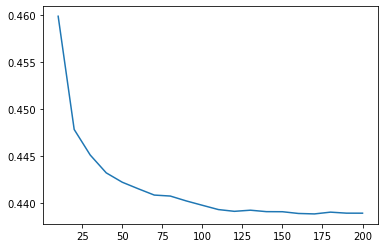

In [40]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

__*Answer Q3: 120*__

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [50]:
scores = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse_v = rmse(y_val, y_pred)
        scores.append((d, n, rmse_v))

In [51]:
columns = ['max_depth','n_estimators','rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.445596
1,10,20,0.442033
2,10,30,0.441392
3,10,40,0.441541
4,10,50,0.441120


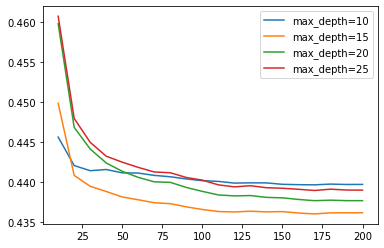

In [52]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)
    
plt.legend()  

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

__*Answer Q4: 15*__  
Answer Q4B: nope

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [54]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_

In [58]:
features = dv.get_feature_names()
feature_importances = pd.DataFrame(zip(features, importances),columns=['feature', 'importance'])
feature_importances.sort_values('importance')

,feature,importance
9,neighbourhood_group=Staten Island,0.000084
5,neighbourhood_group=Bronx,0.000447
8,neighbourhood_group=Queens,0.001034
6,neighbourhood_group=Brooklyn,0.001115
14,room_type=Shared room,0.004158
13,room_type=Private room,0.004877
1,calculated_host_listings_count,0.030264
7,neighbourhood_group=Manhattan,0.034044
10,number_of_reviews,0.042519
4,minimum_nights,0.053170


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

__*Answer Q5: room_type=Entire home/apt*__

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [64]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        columns = ['num_iter','train_sqerr','val_sqerr']
        df_results  = pd.DataFrame(results,columns=columns)
       
    return df_results

In [65]:
import xgboost as xgb

In [66]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [69]:
watchlist = [(dtrain,'train'),(dval,'val')]

In [67]:
scores = {}

In [74]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 4,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=100)

In [75]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

Now change eta first to 0.1 and then to 0.01

What's the best eta?

* 0.3
* 0.1
* 0.01

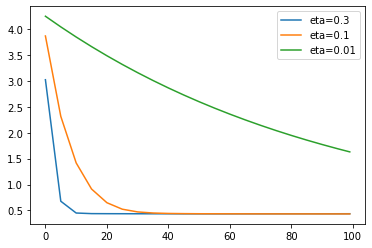

In [81]:
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_sqerr, label=key)
plt.legend()


__*Answer Q6: 0.3*__

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

